## Importing Dependencies

In [1]:
#!pip install catboost
#!pip install lightgbm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.model_selection import  cross_val_score, train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.exceptions import DataConversionWarning



###  Data Loading

In [2]:
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)


print("train: ", train.shape)
print("test: ", test.shape)

ntrain = train.shape[0]
ntest = test.shape[0]


house_data = pd.concat([train,test], axis=0)

train:  (1460, 80)
test:  (1459, 79)


### Data Understanding

In [3]:
house_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

In [4]:
house_data.columns = [col.upper() for col in house_data.columns]
house_data.head()

,MSSUBCLASS,MSZONING,LOTFRONTAGE,LOTAREA,STREET,ALLEY,LOTSHAPE,LANDCONTOUR,UTILITIES,LOTCONFIG,...,POOLAREA,POOLQC,FENCE,MISCFEATURE,MISCVAL,MOSOLD,YRSOLD,SALETYPE,SALECONDITION,SALEPRICE
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [5]:
house_data.drop(['POOLQC','MISCFEATURE','ALLEY'], axis=1, inplace=True)


In [6]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_house_data = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_house_data, end="\n")

    if na_name:
        return na_columns
        
        
# Detailed examination of Missing Values
na_cols = missing_values_table(house_data, True)

              n_miss  ratio
FENCE           2348  80.44
SALEPRICE       1459  49.98
FIREPLACEQU     1420  48.65
LOTFRONTAGE      486  16.65
GARAGECOND       159   5.45
GARAGEQUAL       159   5.45
GARAGEFINISH     159   5.45
GARAGEYRBLT      159   5.45
GARAGETYPE       157   5.38
BSMTCOND          82   2.81
BSMTEXPOSURE      82   2.81
BSMTQUAL          81   2.77
BSMTFINTYPE2      80   2.74
BSMTFINTYPE1      79   2.71
MASVNRTYPE        24   0.82
MASVNRAREA        23   0.79
MSZONING           4   0.14
BSMTFULLBATH       2   0.07
BSMTHALFBATH       2   0.07
FUNCTIONAL         2   0.07
UTILITIES          2   0.07
KITCHENQUAL        1   0.03
TOTALBSMTSF        1   0.03
BSMTUNFSF          1   0.03
BSMTFINSF2         1   0.03
BSMTFINSF1         1   0.03
GARAGECARS         1   0.03
GARAGEAREA         1   0.03
EXTERIOR2ND        1   0.03
EXTERIOR1ST        1   0.03
SALETYPE           1   0.03
ELECTRICAL         1   0.03


In [7]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['GARAGETYPE', 'GARAGEFINISH', 'BSMTFINTYPE2', 'BSMTEXPOSURE', 'BSMTFINTYPE1', 'GARAGECOND', 'GARAGEQUAL', 'BSMTCOND', 'BSMTQUAL', 'FIREPLACEQU', 'FENCE', 'KITCHENQUAL', 'HEATINGQC', 'EXTERQUAL', 'EXTERCOND']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    house_data[col].fillna('NA',inplace=True)
    
missing_values_table(house_data)

              n_miss  ratio
SALEPRICE       1459  49.98
LOTFRONTAGE      486  16.65
GARAGEYRBLT      159   5.45
MASVNRTYPE        24   0.82
MASVNRAREA        23   0.79
MSZONING           4   0.14
BSMTFULLBATH       2   0.07
BSMTHALFBATH       2   0.07
FUNCTIONAL         2   0.07
UTILITIES          2   0.07
EXTERIOR2ND        1   0.03
BSMTFINSF1         1   0.03
BSMTFINSF2         1   0.03
BSMTUNFSF          1   0.03
EXTERIOR1ST        1   0.03
ELECTRICAL         1   0.03
GARAGECARS         1   0.03
GARAGEAREA         1   0.03
SALETYPE           1   0.03
TOTALBSMTSF        1   0.03


In [8]:
house_data.head()

,MSSUBCLASS,MSZONING,LOTFRONTAGE,LOTAREA,STREET,LOTSHAPE,LANDCONTOUR,UTILITIES,LOTCONFIG,LANDSLOPE,...,3SSNPORCH,SCREENPORCH,POOLAREA,FENCE,MISCVAL,MOSOLD,YRSOLD,SALETYPE,SALECONDITION,SALEPRICE
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,NA,0,2,2008,WD,Normal,208500.0
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,NA,0,5,2007,WD,Normal,181500.0
3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,NA,0,9,2008,WD,Normal,223500.0
4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,NA,0,2,2006,WD,Abnorml,140000.0
5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,NA,0,12,2008,WD,Normal,250000.0


In [9]:
#categorical
cols = ['MASVNRTYPE', 'MSZONING', 'EXTERIOR1ST', 'EXTERIOR2ND', 'SALETYPE', 'ELECTRICAL', 'FUNCTIONAL' ]
#categorical


house_data[cols] = house_data.groupby("NEIGHBORHOOD")[cols].transform(lambda x: x.fillna(x.mode()[0]))

missing_values_table(house_data)


              n_miss  ratio
SALEPRICE       1459  49.98
LOTFRONTAGE      486  16.65
GARAGEYRBLT      159   5.45
MASVNRAREA        23   0.79
UTILITIES          2   0.07
BSMTFULLBATH       2   0.07
BSMTHALFBATH       2   0.07
BSMTFINSF1         1   0.03
BSMTFINSF2         1   0.03
BSMTUNFSF          1   0.03
TOTALBSMTSF        1   0.03
GARAGECARS         1   0.03
GARAGEAREA         1   0.03


In [10]:
house_data['MSSUBCLASS'] = house_data['MSSUBCLASS'].apply(str)

### Feature Extraction

## Data Scaling

In [11]:
def rare_encoder(dataframe, rare_perc):
    temp_house_data = dataframe.copy()

    rare_columns = [col for col in temp_house_data.columns if temp_house_data[col].dtypes == 'O'
                    and (temp_house_data[col].value_counts() / len(temp_house_data) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_house_data[var].value_counts() / len(temp_house_data)
        rare_labels = tmp[tmp < rare_perc].index
        temp_house_data[var] = np.where(temp_house_data[var].isin(rare_labels), 'Rare', temp_house_data[var])

    return temp_house_data

house_data=rare_encoder(house_data, 0.01)

house_data['FOUNDATION'].value_counts()

PConc     1308
CBlock    1235
BrkTil     311
Slab        49
Rare        16
Name: FOUNDATION, dtype: int64

In [12]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in house_data.columns if house_data[col].dtype not in [int, float]
               and house_data[col].nunique() == 2]

for col in binary_cols:
    label_encoder(house_data, col)

In [13]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

ohe_cols = [col for col in house_data.columns if 30 >= house_data[col].nunique() > 2]
ohe_cols=ohe_cols.append('NEIGHBORHOOD')
print(ohe_cols)

house_data = one_hot_encoder(house_data, ohe_cols)
house_data.head()

None


,LOTFRONTAGE,LOTAREA,STREET,UTILITIES,CONDITION2,OVERALLQUAL,OVERALLCOND,YEARBUILT,YEARREMODADD,ROOFMATL,...,FENCE_MnPrv,FENCE_NA,FENCE_Rare,SALETYPE_New,SALETYPE_Rare,SALETYPE_WD,SALECONDITION_Family,SALECONDITION_Normal,SALECONDITION_Partial,SALECONDITION_Rare
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,0,0,0,7,5,2003,2003,0,...,0,1,0,0,0,1,0,1,0,0
2,80.0,9600,0,0,0,6,8,1976,1976,0,...,0,1,0,0,0,1,0,1,0,0
3,68.0,11250,0,0,0,7,5,2001,2002,0,...,0,1,0,0,0,1,0,1,0,0
4,60.0,9550,0,0,0,7,5,1915,1970,0,...,0,1,0,0,0,1,0,0,0,0
5,84.0,14260,0,0,0,8,5,2000,2000,0,...,0,1,0,0,0,1,0,1,0,0


In [14]:
house_data.head()

,LOTFRONTAGE,LOTAREA,STREET,UTILITIES,CONDITION2,OVERALLQUAL,OVERALLCOND,YEARBUILT,YEARREMODADD,ROOFMATL,...,FENCE_MnPrv,FENCE_NA,FENCE_Rare,SALETYPE_New,SALETYPE_Rare,SALETYPE_WD,SALECONDITION_Family,SALECONDITION_Normal,SALECONDITION_Partial,SALECONDITION_Rare
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,0,0,0,7,5,2003,2003,0,...,0,1,0,0,0,1,0,1,0,0
2,80.0,9600,0,0,0,6,8,1976,1976,0,...,0,1,0,0,0,1,0,1,0,0
3,68.0,11250,0,0,0,7,5,2001,2002,0,...,0,1,0,0,0,1,0,1,0,0
4,60.0,9550,0,0,0,7,5,1915,1970,0,...,0,1,0,0,0,1,0,0,0,0
5,84.0,14260,0,0,0,8,5,2000,2000,0,...,0,1,0,0,0,1,0,1,0,0


In [15]:
house_data.head()

,LOTFRONTAGE,LOTAREA,STREET,UTILITIES,CONDITION2,OVERALLQUAL,OVERALLCOND,YEARBUILT,YEARREMODADD,ROOFMATL,...,FENCE_MnPrv,FENCE_NA,FENCE_Rare,SALETYPE_New,SALETYPE_Rare,SALETYPE_WD,SALECONDITION_Family,SALECONDITION_Normal,SALECONDITION_Partial,SALECONDITION_Rare
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,0,0,0,7,5,2003,2003,0,...,0,1,0,0,0,1,0,1,0,0
2,80.0,9600,0,0,0,6,8,1976,1976,0,...,0,1,0,0,0,1,0,1,0,0
3,68.0,11250,0,0,0,7,5,2001,2002,0,...,0,1,0,0,0,1,0,1,0,0
4,60.0,9550,0,0,0,7,5,1915,1970,0,...,0,1,0,0,0,1,0,0,0,0
5,84.0,14260,0,0,0,8,5,2000,2000,0,...,0,1,0,0,0,1,0,1,0,0


## Data Splitting

In [16]:
from sklearn.preprocessing import RobustScaler
cols = house_data.select_dtypes(np.number).columns
transformer = RobustScaler().fit(house_data[cols])
house_data[cols] = transformer.transform(house_data[cols])

In [17]:
useless_cols = [col for col in house_data.columns if house_data[col].nunique() == 2 and
                (house_data[col].value_counts() / len(house_data) < 0.01).any(axis=None)]

useless_cols = [col for col in useless_cols if col not in ['ID', 'SALEPRICE']]

house_data.drop(useless_cols, axis=1, inplace=True)

house_data.shape

print(useless_cols)

['STREET', 'LOTSHAPE_Rare', 'LOTCONFIG_Rare', 'LANDSLOPE_Rare', 'EXTERIOR1ST_Rare', 'MASVNRTYPE_Rare', 'EXTERCOND_Rare', 'FOUNDATION_Rare', 'BSMTCOND_Rare', 'HEATINGQC_Rare', 'ELECTRICAL_Rare', 'KITCHENQUAL_Rare', 'FENCE_Rare']


In [18]:
train.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460],
           dtype='int64', name='Id', length=1460)

In [19]:
y = house_data["SALEPRICE"]

In [20]:
X = house_data.loc[train.index]
y = y.loc[train.index]
test = house_data.loc[test.index]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=2023)


In [21]:

print(X_train.shape) 
print(X_val.shape) 
print(y_train.shape) 
print(y_val.shape)

(1095, 196)
(365, 196)
(1095,)
(365,)


## Model Building

In [22]:
def mean_cross_val(model, X, y):
    score = cross_val_score(model, X, y, cv=5)
    mean = score.mean()
    return mean

### XGB_Reg

In [23]:
xgb = XGBRegressor(learning_rate=0.05, 
                   n_estimators=3000,
                   max_depth=10,
                   subsample=0.7
                    )



xgb.fit(X_train, y_train)   
preds = xgb.predict(X_val) 
preds_test_xgb = xgb.predict(test)
mae_xgb = mean_absolute_error(y_val, preds)
rmse_xgb = np.sqrt(mean_squared_error(y_val, preds))
score_xgb = xgb.score(X_val, y_val)
cv_xgb = mean_cross_val(xgb, X, y)


print("MAE : ",mae_xgb)
print("RMSE : ",rmse_xgb)
print("SCORE : ",score_xgb)
print("CV : ",cv_xgb)

MAE :  0.004329613058136385
RMSE :  0.022074943471713574
SCORE :  0.9994314432440907
CV :  0.9973400506794097


### LightGBM

In [24]:
lgbm = LGBMRegressor(max_depth=12,
                    learning_rate=0.01,
                    n_estimators=3000,
                    subsample=0.2,
                    )




lgbm.fit(X_train, y_train)   
preds = lgbm.predict(X_val) 
preds_test_lgbm = lgbm.predict(test)
mae_lgbm = mean_absolute_error(y_val, preds)
rmse_lgbm = np.sqrt(mean_squared_error(y_val, preds))
score_lgbm = lgbm.score(X_val, y_val)
cv_lgbm = mean_cross_val(lgbm, X, y)

print("MAE : ",mae_lgbm)
print("RMSE : ",rmse_lgbm)
print("Score : ",score_lgbm)
print("CV : ",cv_lgbm)

MAE :  0.04098348004683921
RMSE :  0.1676504071168563
Score :  0.9672067961316232
CV :  0.9683723612601284


### Catboost

In [25]:
cb = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')
cb.fit(X_train, y_train)   
preds = cb.predict(X_val) 
preds_test_cb = cb.predict(test)
mae_cb = mean_absolute_error(y_val, preds)
rmse_cb = np.sqrt(mean_squared_error(y_val, preds))
score_cb = cb.score(X_val, y_val)
cv_cb = mean_cross_val(cb, X, y)

print("MAE : ",mae_cb)
print("RMSE : ",rmse_cb)
print("Accuracy Score : ",score_cb)
print("CV Score : ",cv_cb)

MAE :  0.029557237021863584
RMSE :  0.05896345163553056
Accuracy Score :  0.9959436032947157
CV Score :  0.9888752016198735


## Model Evaluation

In [26]:
performance_metrics = pd.DataFrame({
    "Model" : ["XGBoost", "LGBM", "CatBoost"],
    "CV_5" : [str(cv_xgb)[0:5], str(cv_lgbm)[0:5], str(cv_cb)[0:5]],
    "MAE" : [str(mae_xgb)[0:5], str(mae_lgbm)[0:5], str(mae_cb)[0:5]],
    "RMSE" : [str(rmse_xgb)[0:5], str(rmse_lgbm)[0:5], str(rmse_cb)[0:5]],
    "Score" : [str(score_xgb)[0:5], str(score_lgbm)[0:5], str(score_cb)[0:5]]
})


In [27]:
performance_metrics['CV_5']= performance_metrics['CV_5'].astype('float')
performance_metrics['MAE']= performance_metrics['MAE'].astype('float')
performance_metrics['RMSE']= performance_metrics['RMSE'].astype('float')
performance_metrics['Score']= performance_metrics['Score'].astype('float')
performance_metrics

,Model,CV_5,MAE,RMSE,Score
0,XGBoost,0.997,0.004,0.022,0.999
1,LGBM,0.968,0.040,0.167,0.967
2,CatBoost,0.988,0.029,0.058,0.995


Text(0.5, 1.0, ' Model Performances')

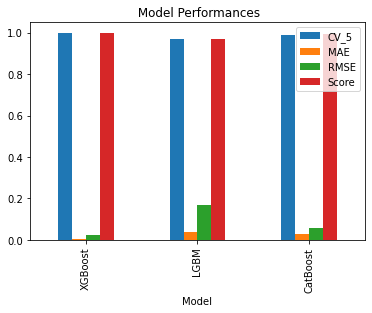

In [30]:
performance_metrics.plot(x="Model", y=[ 'CV_5','MAE', 'RMSE','Score'], kind="bar")
plt.title(" Model Performances")